In [1]:
!pip install -U torchvision

    100% |████████████████████████████████| 2.6MB 12.0MB/s 
    100% |████████████████████████████████| 676.9MB 59kB/s 
  Found existing installation: torch 1.0.1.post2
    Uninstalling torch-1.0.1.post2:
      Successfully uninstalled torch-1.0.1.post2
  Found existing installation: torchvision 0.2.2
    Uninstalling torchvision-0.2.2:
      Successfully uninstalled torchvision-0.2.2
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, utils, datasets

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd
import sklearn

/opt/conda/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(os.listdir("../input/dataset"))
print(os.listdir("../input/dataset/image"))

# Any results you write to the current directory are saved as output.
data_dir = '../input'
label = pd.read_csv(os.path.join(data_dir, "train label.csv"))
data_dir = '../input/dataset'
from shutil import copyfile, copytree, rmtree
os.makedirs('train', exist_ok=True)
os.makedirs('test', exist_ok=True)
os.makedirs('test/x', exist_ok=True)
for u in tqdm(label['Cloth_label'].unique()):
    os.makedirs('train/%d'%u, exist_ok=True)
for _, r in tqdm(label.iterrows(), total=label.shape[0]):
    copyfile(os.path.join(data_dir, 'image/train/%s'%r['Image']), 'train/%d/%s'%(r['Cloth_label'], r['Image']))
rmtree('test/x')
copytree(os.path.join(data_dir, 'image/test'), 'test/x')

['train label.csv', 'dataset']
['image']
['train', 'test']


'test/x'

In [4]:
!nvidia-smi

Mon Jun 17 12:59:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## load image

In [6]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [7]:
import os
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

data_image = {x:ImageFolderWithPaths(root = os.path.join('.',x),
                                     transform = transform)
              for x in ["train", "test"]}
batch_size = 32
data_loader_image = {x:torch.utils.data.DataLoader(dataset=data_image[x],
                                                batch_size = batch_size,
                                                shuffle = True)
                     for x in ["train", "test"]}

In [8]:
data_loader_image

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f184a577a58>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f184a577c88>}

('./train/3/1347054295_0.jpg', './train/5/1131269067_0.jpg', './train/1/1103086594_0.jpg', './train/6/1293996696_0.jpg', './train/4/1095658103_0.jpg', './train/3/1097142198_0.jpg', './train/0/1038030631_0.jpg', './train/0/1023800584_0.jpg', './train/5/1032733129_0.jpg', './train/4/1480987525_0.jpg', './train/7/1451320678_0.jpg', './train/7/1472844404_0.jpg', './train/7/1289263166_0.jpg', './train/3/1036568411_0.jpg', './train/3/1359358252_0.jpg', './train/5/1461690048_0.jpg', './train/7/1137943800_0.jpg', './train/4/1479254530_0.jpg', './train/3/1316013687_0.jpg', './train/1/1141822860_0.jpg', './train/7/1430269559_0.jpg', './train/7/1282268455_0.jpg', './train/0/1480351237_0.jpg', './train/3/1311387922_0.jpg', './train/5/1036072055_0.jpg', './train/6/1053532776_0.jpg', './train/1/1018201140_0.jpg', './train/3/1349471291_0.jpg', './train/1/1177130383_0.jpg', './train/7/1454884692_0.jpg', './train/0/1020967665_0.jpg', './train/1/1164105775_0.jpg')
[tensor(3), tensor(5), tensor(1), tenso

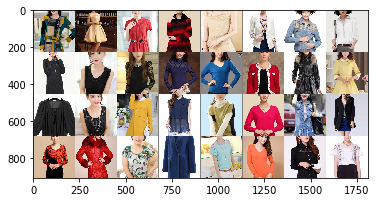

In [9]:
X_train, y_train, X_name = next(iter(data_loader_image["train"]))
mean = [0.5,0.5,0.5]
std  = [0.5,0.5,0.5]
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))
img = img*std+mean

print(X_name)
print([i for i in y_train])
plt.imshow(img)


In [10]:
net = torchvision.models.resnext101_32x8d(pretrained=True)
net.fc = torch.nn.Linear(2048, 8)
net = net.to(device)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /tmp/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 356082095/356082095 [00:04<00:00, 75743681.12it/s]


In [11]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stri

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
epoch = 5

In [13]:
def train():
    net.train()
    total_loss = 0
    for image, label, name in tqdm(data_loader_image['train'], leave=False):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()

        target = net(image)
        loss = criterion(target, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss/float(len(data_loader_image['train']))


In [14]:
lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
epoch = 10
for i in tqdm(range(epoch)):
    print(train())
lr /= 5
print(lr)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
for i in tqdm(range(epoch)):
    print(train())
lr /= 5
print(lr)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
for i in tqdm(range(epoch)):
    print(train())
lr /= 5
print(lr)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
for i in tqdm(range(epoch)):
    print(train())

1.1395250922550184


0.7328106128698424


0.6134825650500672


0.5387473199006997


0.4921960015653839


0.4548845682349792


0.4172683385707506


In [15]:
torch.save(net, 'train_model.pkl')

In [16]:
net = torch.load('train_model.pkl').to(device)

In [17]:
validation_set = torch.utils.data.DataLoader(dataset=data_image["train"],
                                                batch_size = 20,
                                                shuffle = False)
def evaluate():
    net.eval()
    corrects = eval_loss = 0

    for image, label, name in tqdm(validation_set, leave=False):
        image = image.to(device)
        label = label.to(device) 
        pred = net(image)
        loss = criterion(pred, label)

        eval_loss += loss.item()
        corrects += (torch.max(pred, 1)[1].view(label.size()).data == label.data).sum()
    return eval_loss/float(len(data_loader_image['train'])), corrects, corrects*100/batch_size/len(data_loader_image['train'])

In [18]:
evaluate()

(0.003022107854573924,
 tensor(21025, device='cuda:0'),
 tensor(99, device='cuda:0'))

In [19]:
test_set = torch.utils.data.DataLoader(dataset=data_image["test"],
                                                batch_size = 1,
                                                shuffle = False)

In [20]:

def test():
    net.eval()
    corrects = eval_loss = 0
    result = []
    for image, label, name in tqdm(test_set):
        image = image.to(device)
        label = label.to(device) 
        pred = net(image)
        
        result.append([name, torch.max(pred, 1)[1].view(label.size()).data])
    return result

In [21]:
results = test()

In [22]:
processed_res = []
for r in results:
    path = r[0][0].split('/')[-1]
    cloth = r[1][0].item()
    processed_res.append([path, cloth])

In [23]:
res_df = pd.DataFrame(processed_res)
res_df.columns = ['Image', 'Cloth_label']

In [24]:
res_df['Cloth_label'].unique()

array([7, 3, 0, 5, 1, 4, 2, 6])

In [25]:
res_df.to_csv('res.csv', index=False)

In [26]:
rmtree('test')
rmtree('train')

In [27]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stri